<a href="https://colab.research.google.com/github/Emmanuel-Ayeni/creditRiskAssessment/blob/main/creditRiskAssessmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check Python version and install missing packages
!python --version
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm shap keras tensorflow


Python 3.11.11


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/kaggle"


home-credit-default-risk.zip


In [4]:
zip_path = "/content/drive/My Drive/kaggle/home-credit-default-risk.zip"

In [5]:
!cp "{zip_path}" /content/

## Unzip the file into a new directory

In [6]:

import zipfile
import os

# Create target directory
target_dir = "/content/my_unzipped_data"
os.makedirs(target_dir, exist_ok=True)

# Unzip
with zipfile.ZipFile("/content/home-credit-default-risk.zip", 'r') as zip_ref:
    zip_ref.extractall(target_dir)

# Check contents
!ls "{target_dir}"


application_test.csv   credit_card_balance.csv		   previous_application.csv
application_train.csv  HomeCredit_columns_description.csv  sample_submission.csv
bureau_balance.csv     installments_payments.csv
bureau.csv	       POS_CASH_balance.csv


## Import libraries

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

import shap
import warnings
warnings.filterwarnings('ignore')


## Load all CSVs

In [8]:

path = '/content/my_unzipped_data/'

application_train = pd.read_csv(path + 'application_train.csv')
application_test = pd.read_csv(path + 'application_test.csv')
bureau = pd.read_csv(path + 'bureau.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
pos_cash_balance = pd.read_csv(path + 'POS_CASH_balance.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
desc = pd.read_csv(path + 'HomeCredit_columns_description.csv', encoding='latin-1')


## Explore the Main Dataset

In [9]:
# Explore the Main Dataset
application_train.head()
application_train['TARGET'].value_counts(normalize=True)

,proportion
TARGET,
0,0.919271
1,0.080729


Text(0.5, 1.0, 'Target Class Distribution')

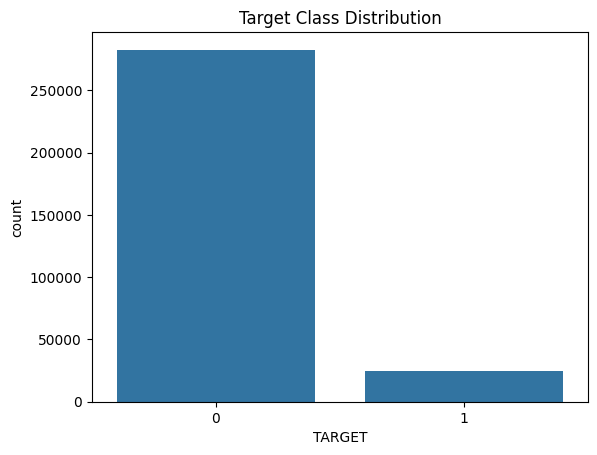

In [10]:
sns.countplot(x='TARGET', data=application_train)
plt.title("Target Class Distribution")


## Feature Engineering (Simple Baseline)

In [11]:

# Encode categorical features
def label_encode(df):
    le = LabelEncoder()
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
    return df

app_train = label_encode(application_train.copy())
app_test = label_encode(application_test.copy())

# Align train and test data
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join='inner', axis=1)


## Scale Features

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(app_train)
X_test = scaler.transform(app_test)
y = train_labels


In [13]:
X

array([[-1.73342255, -0.32439532,  1.38801505, ..., -0.29191601,
        -0.33432751, -0.48145217],
       [-1.73341283, -0.32439532, -0.72036997, ..., -0.29191601,
        -0.33432751, -1.01641421],
       [-1.7334031 ,  3.08265852,  1.38801505, ..., -0.29191601,
        -0.33432751, -1.01641421],
       ...,
       [ 1.73239096, -0.32439532, -0.72036997, ...,  0.79978625,
        -0.33432751, -0.48145217],
       [ 1.73240069, -0.32439532, -0.72036997, ..., -0.29191601,
        -0.33432751, -1.01641421],
       [ 1.73241042, -0.32439532, -0.72036997, ...,  1.8914885 ,
        -0.33432751, -0.48145217]])

## Train/Test Split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Build Deep Learning Model

In [15]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256)


Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - AUC: 0.5002 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 3/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 4/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 5/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 6/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 7/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 8/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_loss: nan
Epoch 9/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.5000 - loss: nan - val_AUC: 0.5000 - val_l

 ### First Machine Learning Pipeline
 The model is completely failing to learn—the loss is nan and AUC is 0.0 every epoch. This likely stems from bad input data, label issues, or numerical instability in the loss function. The real work starts from here ........... There is the need to check labels, inspect the input, do some data cleansing & etc.

## Pre-Processing Data
*   Handle missing values (e.g., impute with mean/median, drop rows).
*   Remove or correct outliers if necessary.
*   Encode categorical variables (e.g., one-hot encoding for "red," "blue,"     
    "green").
*   Dimensionality Reduction (e.g., Principal Component Analysis, t-SNE,
    others).


In [16]:
# Preprocessing steps

def preprocess_data(df):
    # 1. Handle missing values (Imputation)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])  # Mode for categorical
        else:
            df[col] = df[col].fillna(df[col].median())  # Median for numerical

    # 2. Encode categorical features (Label Encoding)
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = le.fit_transform(df[col])

    # 3. Scale numerical features (MinMax Scaling)
    scaler = MinMaxScaler()
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df

# Apply preprocessing to each dataset
application_train = preprocess_data(application_train)
application_test = preprocess_data(application_test)
bureau = preprocess_data(bureau)
bureau_balance = preprocess_data(bureau_balance)
credit_card_balance = preprocess_data(credit_card_balance)
installments_payments = preprocess_data(installments_payments)
pos_cash_balance = preprocess_data(pos_cash_balance)
previous_application = preprocess_data(previous_application)



In [17]:
# Separate features and target
X = application_train.drop('TARGET', axis=1)
y = application_train['TARGET']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Scale Features
scaler = StandardScaler()
X = scaler.fit_transform(app_train)
X_test = scaler.transform(app_test)
y = train_labels

## Build Deep Learning Model

In [19]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256)


Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.6332 - loss: 0.2808 - val_AUC: 0.7394 - val_loss: 0.2521
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7149 - loss: 0.2557 - val_AUC: 0.7410 - val_loss: 0.2517
Epoch 3/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7215 - loss: 0.2573 - val_AUC: 0.7410 - val_loss: 0.2538
Epoch 4/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7247 - loss: 0.2571 - val_AUC: 0.7419 - val_loss: 0.2512
Epoch 5/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7266 - loss: 0.2554 - val_AUC: 0.7430 - val_loss: 0.2511
Epoch 6/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7263 - loss: 0.2551 - val_AUC: 0.7429 - val_loss: 0.2506
Epoch 7/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7253 - loss: 0.2542 - val_AUC: 0.7430 - val_loss: 0.2507
Epoch 8/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7310 - loss: 0.2545 - val_AUC: 0.7434 - val_loss: 0.2506
Epoch 9/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - A

## Evaluate Model


In [20]:
y_pred = model.predict(X_val).flatten()
print("ROC AUC:", roc_auc_score(y_val, y_pred))

# Thresholding for classification report
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
ROC AUC: 0.7434548917308849
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



####  The ROC AUC of ~0.74, seems like a decent start for a baseline model, but the classification report shows a major red flag.



*   The model is predicting only class 0 (non-default) because the precision and recall for class 1 are 0.
*   It avoids the misclassifying the rare 8% (credit risk)



## Handle Imbalance Classes
*   Use Class weights
*   oversample class 1 (SMOTE) or undersample class 0

In [22]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=10, batch_size=256, class_weight=class_weights)

Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.7039 - loss: 0.6378 - val_AUC: 0.7433 - val_loss: 0.5830
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7290 - loss: 0.6113 - val_AUC: 0.7436 - val_loss: 0.5135
Epoch 3/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7327 - loss: 0.6107 - val_AUC: 0.7434 - val_loss: 0.6133
Epoch 4/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7326 - loss: 0.6071 - val_AUC: 0.7441 - val_loss: 0.6183
Epoch 5/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7344 - loss: 0.6059 - val_AUC: 0.7435 - val_loss: 0.5675
Epoch 6/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7359 - loss: 0.6032 - val_AUC: 0.7443 - val_loss: 0.5908
Epoch 7/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7369 - loss: 0.6038 - val_AUC: 0.7441 - val_loss: 0.5975
Epoch 8/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - AUC: 0.7369 - loss: 0.6021 - val_AUC: 0.7445 - val_loss: 0.6194
Epoch 9/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AU

In [23]:
y_pred = model.predict(X_val).flatten()
print("ROC AUC:", roc_auc_score(y_val, y_pred))

# Thresholding for classification report
print(classification_report(y_val, (y_pred > 0.5).astype(int)))

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
ROC AUC: 0.7441369611333957
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56538
         1.0       0.16      0.66      0.26      4965

    accuracy                           0.70     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.89      0.70      0.77     61503



### Classification Results
This result is much better from an explainability and usefulness perspective, even though the overall accuracy dropped.

#### Class 1 (Defaults):
*   Recall is now 66% — this means the model catches two-thirds of actual defaults. This seems like a huge win in credit risk compared to the previous model.

*   Precision is still low (0.16) — so there are false positives (predicting default where there isn’t one), but...

*   In credit scoring, false positives are less costly than false negatives.
*   Accuracy dropped to 70% (from 92%), but that's expected.

*   This is a better model, because it's no longer blindly predicting "no default" for everyone.

### Threshold Tuning

*   Change the default 0.5 to a range of thresholds [0.1, 0.9, 0.1] and see how it affects precision/recall for the minority class (Class 1)

In [24]:
# Get predicted probabilities
y_pred_probs = model.predict(X_val).flatten()

# Evaluate at different thresholds
thresholds = np.arange(0.1, 0.9, 0.1)
for t in thresholds:
    preds = (y_pred_probs > t).astype(int)
    print(f"Threshold: {t:.1f}")
    print(classification_report(y_val, preds, digits=3))

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Threshold: 0.1
              precision    recall  f1-score   support

         0.0      0.994     0.016     0.032     56538
         1.0      0.082     0.999     0.151      4965

    accuracy                          0.096     61503
   macro avg      0.538     0.508     0.092     61503
weighted avg      0.920     0.096     0.042     61503

Threshold: 0.2
              precision    recall  f1-score   support

         0.0      0.985     0.110     0.198     56538
         1.0      0.088     0.981     0.162      4965

    accuracy                          0.180     61503
   macro avg      0.537     0.546     0.180     61503
weighted avg      0.913     0.180     0.195     61503

Threshold: 0.3
              precision    recall  f1-score   support

         0.0      0.978     0.290     0.448     56538
         1.0      0.103     0.926     0.185      4965

    accuracy                          0.342     61503
   macro avg      0.540     0.608     0.

## Explainability with SHAP

In [21]:
# DeepExplainer only works well with small samples, so sample the data
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_val[:100])

shap.summary_plot(shap_values[0], X_val[:100], feature_names=application_train.columns.drop('TARGET'))

KeyError: 0

## Exploratory Data Analysis (EDA)

Data Exploration (EDA - Exploratory Data Analysis):
*   Visualise data (e.g., histograms, scatter plots) to understand
    distributions and relationships.
*   Check for missing values, outliers, or inconsistencies.
*   Target Variable: Understanding the distribution of the target variable (TARGET) is crucial. The sns.countplot helps visualise the class imbalance (if any).
*   Numerical Features: Histograms provide insights into the distribution of numerical features, revealing potential outliers or skewness.
*   Correlation: The correlation matrix shows relationships between numerical features, highlighting potential multicollinearity.
Categorical Features: Countplots are used to visualize the distribution of categorical features, helping identify dominant categories.
*   Specific Features: The code provides examples of exploring specific features like credit types, status, balances, payment delays, and contract statuses. You can adapt and extend this to explore other features of interest.



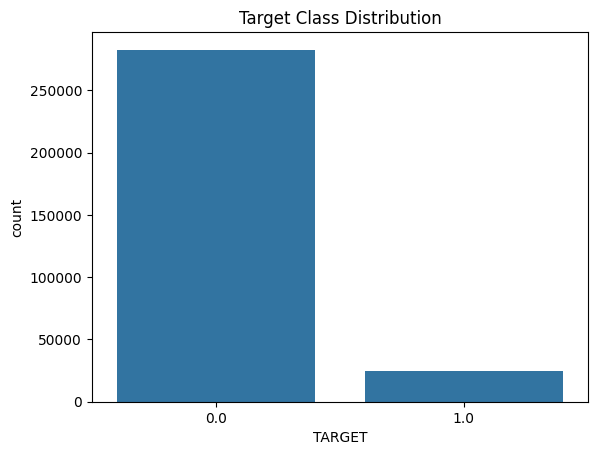

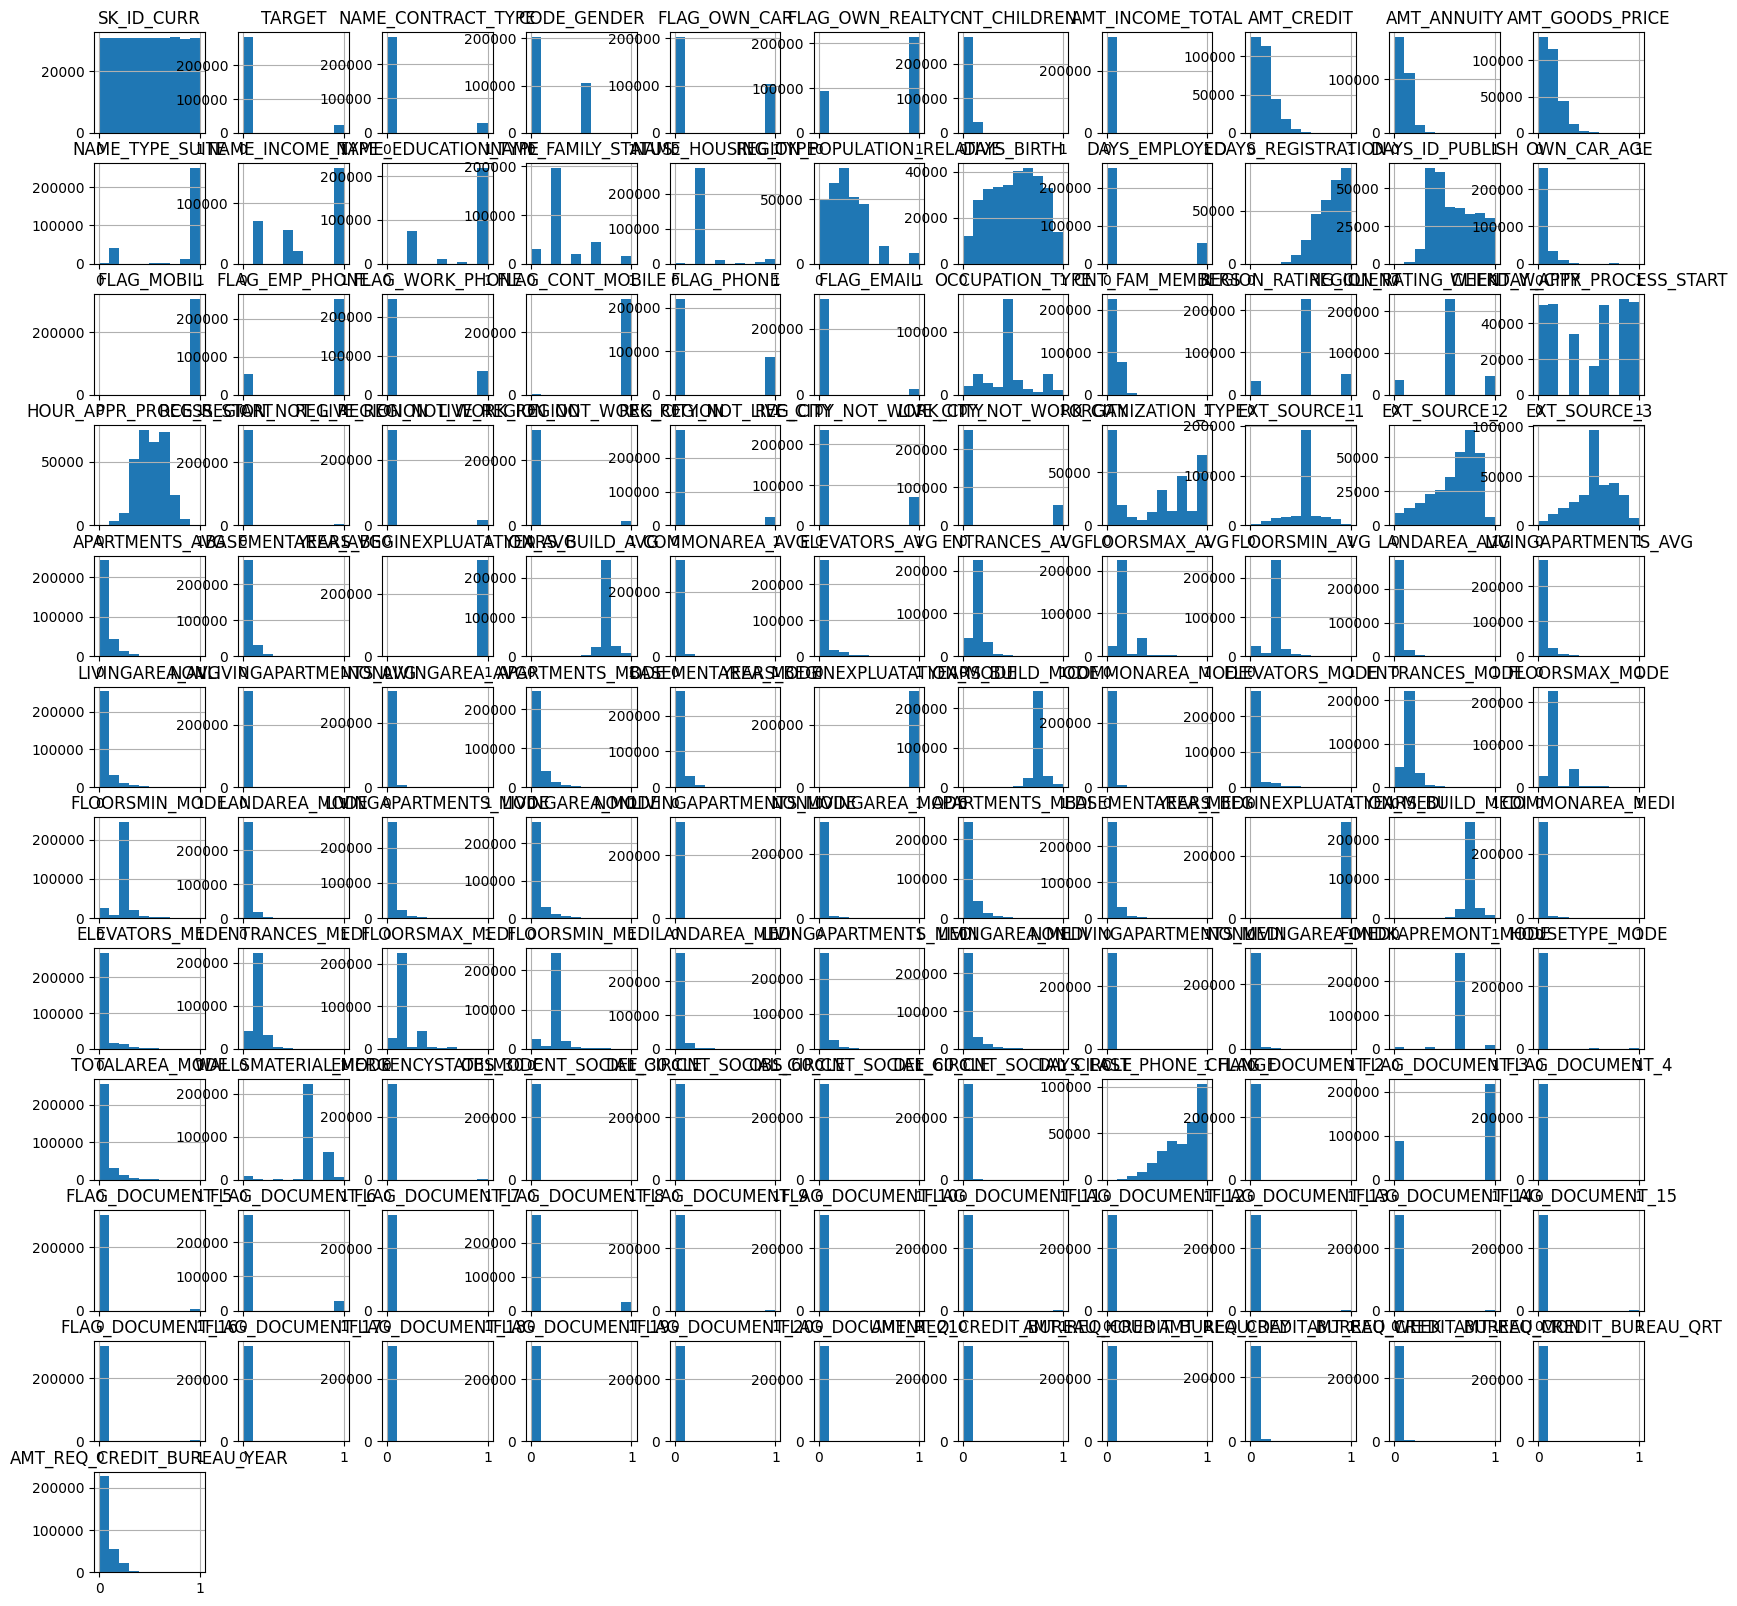

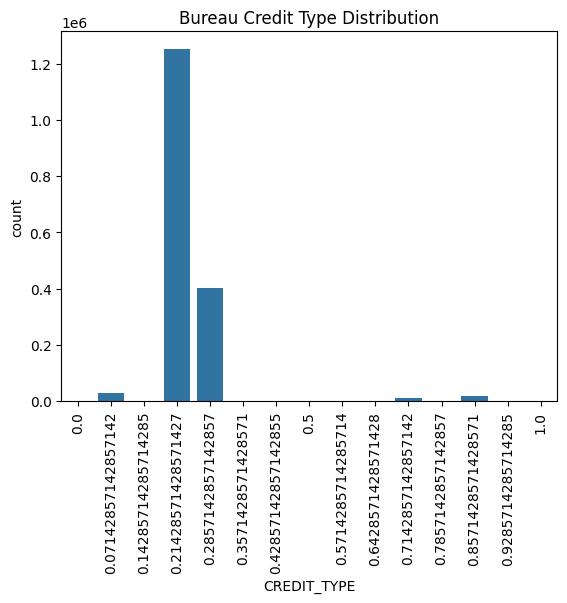

In [ ]:
# --- Application Train & Test ---
# Target variable distribution
sns.countplot(x='TARGET', data=application_train)
plt.title("Target Class Distribution")
plt.show()

# Distribution of numerical features
application_train.hist(figsize=(20, 20))
plt.show()

# Correlation matrix
#corr_matrix = application_train.corr()
#sns.heatmap(corr_matrix, cmap='coolwarm')
#plt.title("Correlation Matrix")
#plt.show()

# --- Bureau ---
# Distribution of credit types
sns.countplot(x='CREDIT_TYPE', data=bureau)
plt.title("Bureau Credit Type Distribution")
plt.xticks(rotation=90)
plt.show()

# --- Bureau Balance ---
# Distribution of status
sns.countplot(x='STATUS', data=bureau_balance)
plt.title("Bureau Balance Status Distribution")
plt.show()

# --- Credit Card Balance ---
# Distribution of previous credit card balance
sns.histplot(credit_card_balance['AMT_BALANCE'])
plt.title("Credit Card Balance Distribution")
plt.show()

# --- Installments Payments ---
# Distribution of payment delay
sns.histplot(installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT'])
plt.title("Installments Payment Delay Distribution")
plt.show()

# --- POS Cash Balance ---
# Distribution of contract status
sns.countplot(x='NAME_CONTRACT_STATUS', data=pos_cash_balance)
plt.title("POS Cash Balance Contract Status Distribution")
plt.xticks(rotation=90)
plt.show()

# --- Previous Application ---
# Distribution of contract status
sns.countplot(x='NAME_CONTRACT_STATUS', data=previous_application)
plt.title("Previous Application Contract Status Distribution")
plt.xticks(rotation=90)
plt.show()